# Analysis Summary

This notebook provides answers to questions about the open-coding analysis process itself.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from IPython.display import display, Markdown
from lib.util import getCodes

Import all codes from the open coding process

In [2]:
%%time
codes = getCodes()

CPU times: user 32.7 s, sys: 80 ms, total: 32.8 s
Wall time: 33.1 s


Parse works cited section of the `README.md` document for more analysis information.

In [3]:
# See regular expression at regexr.com/4htcn
regxp = r'\n([^\n\.\#]+)\.\s\((\d{4}),\s(\w+)\s(\d+)\)\.\s([^\.]+\.)\s\*([\w\d\s]+)\*\.\sRetrieved from (.*)\n'
with open('README.md') as readme:
    content = readme.read();

citations = re.findall(regxp,content)
citations = pd.DataFrame(citations, columns=['journalist', 'year', 'month', 'date', 'article', 'organization', 'url'])
citations.head()

,journalist,year,month,date,article,organization,url
0,"Aldhous, Peter",2016,September,16,"""Shy Trumpers"" polling analysis.",BuzzFeed News,https://github.com/BuzzFeedNews/2016-09-shy-tr...
1,"Arthur, Rob",2015,July,30,Buster Posey MVP.,FiveThirtyEight,https://github.com/fivethirtyeight/data
2,"Bi, Frank",2016,Jan,13,Uber launch cities and date.,Forbes,https://github.com/voxmedia/data-projects
3,"Bradshaw, Paul",2019,April,6,Lack of electric car charging points 'putting ...,BBC,https://github.com/BBC-Data-Unit/electric-car-...
4,"Bradshaw, Paul",2019,March,8,Birmingham remains top destination for Londoners.,BBC,https://github.com/BBC-Data-Unit/internal-migr...


Also get the list of data journalism repos identified in `find_notebooks.ipynb`. 

In [4]:
repos = pd.read_csv('potential_notebooks.csv')
keepers = repos[repos.is_keeper == True]

## Analysis by the numbers

In [5]:
byTheNumbers = citations.loc[:,['journalist', 'organization', 'article']].describe().loc['unique',:].to_frame('count')
byTheNumbers = byTheNumbers.append(pd.DataFrame({
        'count': [ codes.code.nunique(), 
                   repos.shape[0],
                   keepers.shape[0],
                   keepers.org.nunique(),
                 ],
    }, index=['codes', 'repos', 'relevant repos', 'total organizations']))

byTheNumbers

,count
journalist,21
organization,17
article,34
codes,153
repos,1295
relevant repos,225
total organizations,50


## Progress towards convergence

In [6]:
codingOrder = pd.DataFrame({'article': [
    'federal_employees_trump_2017', 
    'infrastructure-jobs',
    'librarians',
    'midwife-led-units',
    'internal-migration-london',
    'electric-car-charging-points',
    'school-star-ratings-2018',
    'prison-admissions',
    'vox-central-line-infections',
    'verge-uber-launch-dates',
    'buster-posey-mvp',
    'work-from-home',
    'nyc-trips',
    'bob-ross',
    'bechdel',
    'employment-discrimination',
    '2015-11-refugees-in-the-united-states',
    'babyname_politics',
    'wikipedia-rankings',
    'Power_of_Irma',
    'Endangered-Species-Act-Louisiana',
    'california-h2a-visas-analysis',
    '2016-04-republican-donor-movements',
    'cube_root_law',
    '2016-09-shy-trumpers',
    '2018-05-31-crime-and-heat-analysis',
    '2016-11-bellwether-counties',
    'heat_and_humidity',
    '2018-voter-registration',
    'long-term-care-db',
    'census-hard-to-map-analysis',
    'california-crop-production-wages-analysis',
    'california-cc-score-analysis',
    '2019-04-democratic-candidate-codonors',
    'california-ccscore-analysis'
][::-1] }).reset_index().rename(columns={'index': 'coding order'})

Create a data frame of codes grouped by article.

In [7]:
codesByArticle = codes.groupby(['article']).code \
    .unique() \
    .to_frame('codes') \
    .reset_index() \
    .merge(codingOrder, on='article') \
    .sort_values('coding order') \
    .reset_index()

codesByArticle['cumulative count'] = 0
#codesByArticle['cumulative codeset'] = None

codeset = set()
for i, row in codesByArticle.iterrows():
    setDiff = set(row.codes).difference(codeset)
    codeset = codeset.union(setDiff)
    codesByArticle.loc[i, 'cumulative count'] = len(codeset)
    codesByArticle.loc[i, 'new codes'] = ', '.join(setDiff)

codesByArticle.head()

,index,article,codes,coding order,cumulative count,new codes
0,13,california-ccscore-analysis,"[format table display, read as tabular data, d...",0,23,"filter rows, adjust for season, remove incompl..."
1,6,2019-04-democratic-candidate-codonors,"[use public data, read as tabular data, archit...",1,42,"calculate scaled ratio, self join table, remov..."
2,14,california-crop-production-wages-analysis,"[use public data, format table display, constr...",3,45,"construct table manually, adjust for inflation..."
3,16,census-hard-to-map-analysis,"[wrangle data for graphics, use public data, c...",4,47,"slice column values, wrangle data for graphics"
4,25,long-term-care-db,"[count value frequency, calculate scaled ratio...",5,56,"join with lookup table, use non-public, provid..."


Plot the size of the code set as more computational notebooks are analyzed.

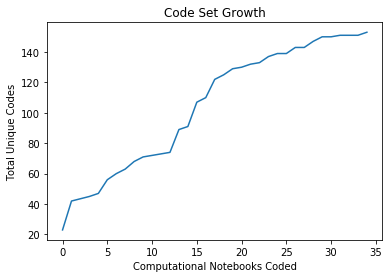

In [8]:
ax = sns.lineplot(x='coding order', y='cumulative count', markers=True, dashes=False, data=codesByArticle)
ax.set(xlabel='Computational Notebooks Coded', ylabel='Total Unique Codes', title='Code Set Growth')
plt.show()

Map codes back to the article where they were introduced to the code set.

In [9]:
for i, row in codesByArticle.iterrows():
    display(Markdown('{}. **{}**: {}'.format(i + 1, row.article, row['new codes'])))

1. **california-ccscore-analysis**: filter rows, adjust for season, remove incomplete data, calculate percentage difference, drop columns, export results, count number of records, inspect table schema, read as tabular data, split, compute, and merge, plot histogram, calculate mean, calculate z-score, group by single column, repetitive code, count value frequency, drop entirely duplicate rows, peek at data, change column data type, format table display, sort table, inner join tables, calculate difference

2. **2019-04-democratic-candidate-codonors**: calculate scaled ratio, self join table, remove with regular expression, strip whitespace, calculate ratio, count unique values in column, annotate workflow, change case, gather table, canonicalize column names, group by multiple columns, outer join tables, prevent double-counting, create a semi-unique key, use public data, export intermediate results, union tables, architect a subroutine, sum column values

3. **california-crop-production-wages-analysis**: construct table manually, adjust for inflation, architect repeating process

4. **census-hard-to-map-analysis**: slice column values, wrangle data for graphics

5. **long-term-care-db**: join with lookup table, use non-public, provided data, drop erroneous rows, perform name entity resolution manually, encode table identification in row, construct pivot table, scrape web for data, fix data errors manually, drop rows with duplicate value in one column

6. **2018-voter-registration**: plot stacked column chart, pull tables out of pdf, plot stacked bar chart, extract single value

7. **heat_and_humidity**: cartesian product, compute index number, generate data computationally

8. **2016-11-bellwether-counties**: get max value, use academic data, spread table, calculate spread, create rolling window

9. **2018-05-31-crime-and-heat-analysis**: extract property from datetime, combine seemingly disparate datasets, plot scatterplot

10. **2016-09-shy-trumpers**: use another news orgs data

11. **cube_root_law**: calculate using an external data structure

12. **2016-04-republican-donor-movements**: split column on delimiter

13. **california-h2a-visas-analysis**: omits data quality exploration, trim by geographic area, trim by date range, remove all rows but the master record, replace na values, encoding provenance in data, preserve existing values, display entire table, temporary joining column, create a crosstab, plot column chart, cache results from external service, create a unique key, split and compute, geocode addresses

14. **Endangered-Species-Act-Louisiana**: plot trendline, perform scalar multiplication

15. **Power_of_Irma**: fit a generalized linear model, fix incorrect calculation, find most frequently occurring, change date format, value replacement, plot boxplot, toggle step on and off, plot violin plot, use previously cleaned data, use data from colleague, look for trends, select columns, tolerate dirty data, find worst offender, log-ify values, set data confidence threshold

16. **wikipedia-rankings**: collect raw data, plot scree plot, analyze principle components

17. **babyname_politics**: break ties, get unique values, resort after merge, trim by quantitative threshold, join aggregate, assign ranks, data loss from aggregation, concatenate columns into key, round floating point, check results of previous operation, natural join, peel and merge

18. **2015-11-refugees-in-the-united-states**: designate column as primary key, compare total number of rows, make an incorrect conclusion

19. **employment-discrimination**: combine entities by string matching, concatenate files together, merge tables to create pivot table, align table columns for consolidation

20. **bechdel**: calculate median

21. **bob-ross**: run cluster analysis, whiten matrix

22. **nyc-trips**: full join tables

23. **work-from-home**: translate entity names manually, test for equality, data too large for repo, create flag

24. **buster-posey-mvp**: plot line chart, image analysis

25. **verge-uber-launch-dates**: 

26. **vox-central-line-infections**: report rows with column number discrepancies, filter by contains value, remove delimiting characters, sort table rows

27. **prison-admissions**: 

28. **school-star-ratings-2018**: pad column values, get min value, reconcile primary keys between tables, display rows with errors

29. **electric-car-charging-points**: encode redundant information, define edge weights, add foreign key column

30. **internal-migration-london**: 

31. **midwife-led-units**: test different computations for equality

32. **librarians**: 

33. **infrastructure-jobs**: 

34. **federal_employees_trump_2017**: resolve to arbitrary entity name among choices, create a table to lookup values

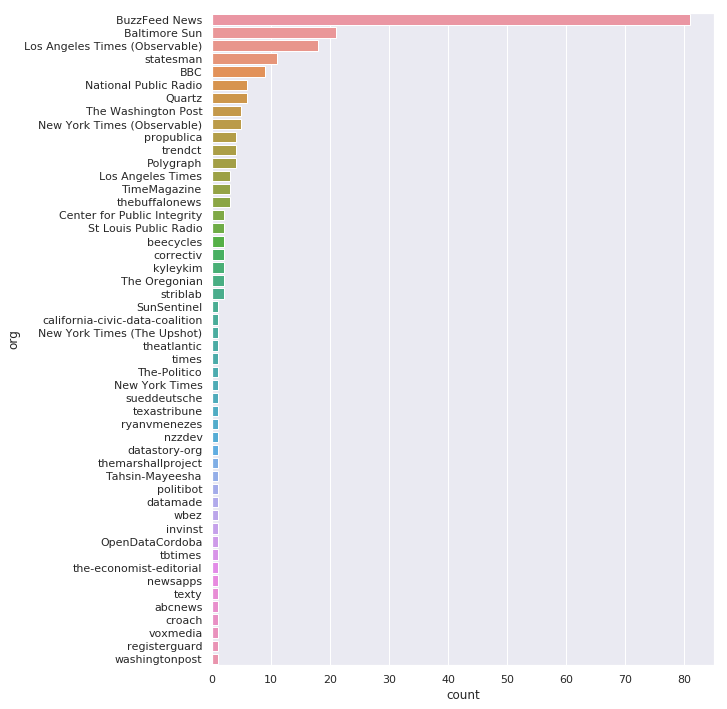

In [10]:
sns.set(rc={'figure.figsize': (9,12)})
sns.countplot(y='org', 
              data=keepers,
              order=keepers.org.value_counts().index)